In [23]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score


In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [25]:
# Loading Data
df = pd.read_csv("/Users/tattwamasiray/Downloads/Monash-BOOTCAMP/Fraud in financial payment /PS_20174392719_1491204439457_log.csv")
(df.head())
df.info()
unique_counts=df.nunique()
print(unique_counts)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64


Exploratory Data Analysis and EDA and Fraud detection

The provided data has the financial transaction data as well as the target variable isFraud, which is the actual fraud status of the transaction and isFlaggedFraud is the indicator which the simulation is used to flag the transaction using some threshold.

The goal should be how we can improve and come up with better threshold to capture the fraud transaction.

In [26]:
summarydata = df.describe()
print(summarydata)

               step        amount  oldbalanceOrg  newbalanceOrig  \
count  6.362620e+06  6.362620e+06   6.362620e+06    6.362620e+06   
mean   2.433972e+02  1.798619e+05   8.338831e+05    8.551137e+05   
std    1.423320e+02  6.038582e+05   2.888243e+06    2.924049e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.338957e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.487194e+04   1.420800e+04    0.000000e+00   
75%    3.350000e+02  2.087215e+05   1.073152e+05    1.442584e+05   
max    7.430000e+02  9.244552e+07   5.958504e+07    4.958504e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    6.362620e+06    6.362620e+06  6.362620e+06    6.362620e+06  
mean     1.100702e+06    1.224996e+06  1.290820e-03    2.514687e-06  
std      3.399180e+06    3.674129e+06  3.590480e-02    1.585775e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.000000e+00    0.000000e+00

In [27]:
df.isnull().values.any()

False

In [28]:
print(df.value_counts())

step  type      amount      nameOrig     oldbalanceOrg  newbalanceOrig  nameDest     oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud
1     CASH_IN   270.78      C619985571   4184966.65     4185237.43      C875917495   3019.00         0.00            0        0                 1
306   CASH_OUT  220427.13   C1029846599  0.00           0.00            C129321077   882543.64       1102970.77      0        0                 1
                221047.89   C644407995   13756.00       0.00            C1396283314  9082.00         0.00            0        0                 1
                221009.03   C74685400    102768.00      0.00            C1714223283  767644.73       988653.76       0        0                 1
                220986.46   C540058568   9141.00        0.00            C1344091292  0.00            220986.46       0        0                 1
                                                                                                                                 

In [29]:
# Rename columns using a dictionary
df.rename(columns={
    'step': 'transaction_step',
    'type': 'transaction_type',
    'amount': 'transaction_amount',
    'nameOrig': 'originator_name',
    'oldbalanceOrg': 'originator_old_balance',
    'newbalanceOrig': 'originator_new_balance',
    'nameDest': 'destination_name',
    'oldbalanceDest': 'destination_old_balance',
    'newbalanceDest': 'destination_new_balance',
    'isFraud': 'fraud_status',
    'isFlaggedFraud': 'flagged_fraud_status'
}, inplace=True)

# Display the updated DataFrame
print(df.head())

   transaction_step transaction_type  transaction_amount originator_name  \
0                 1          PAYMENT             9839.64     C1231006815   
1                 1          PAYMENT             1864.28     C1666544295   
2                 1         TRANSFER              181.00     C1305486145   
3                 1         CASH_OUT              181.00      C840083671   
4                 1          PAYMENT            11668.14     C2048537720   

   originator_old_balance  originator_new_balance destination_name  \
0                170136.0               160296.36      M1979787155   
1                 21249.0                19384.72      M2044282225   
2                   181.0                    0.00       C553264065   
3                   181.0                    0.00        C38997010   
4                 41554.0                29885.86      M1230701703   

   destination_old_balance  destination_new_balance  fraud_status  \
0                      0.0                      0.0  

In [30]:
# List of unique transaction types for fraudulent transactions
fraudulent_transaction_types = df.loc[df.fraud_status == 1, 'transaction_type'].drop_duplicates().values

print('\nThe types of fraudulent transactions are:', fraudulent_transaction_types)

# Filter fraudulent transactions of type 'TRANSFER'
df_fraud_transfer = df.loc[(df.fraud_status == 1) & (df.transaction_type == 'TRANSFER')]

# Filter fraudulent transactions of type 'CASH_OUT'
df_fraud_cash_out = df.loc[(df.fraud_status == 1) & (df.transaction_type == 'CASH_OUT')]

print('\nThe number of fraudulent TRANSFERs =', len(df_fraud_transfer))
print('The number of fraudulent CASH_OUTs =', len(df_fraud_cash_out))



The types of fraudulent transactions are: ['TRANSFER' 'CASH_OUT']

The number of fraudulent TRANSFERs = 4097
The number of fraudulent CASH_OUTs = 4116


Feature Engineering:
Create new features based on patterns you want to capture:

In [31]:
# Example 1: Creating a feature for the difference between old and new balances for originator
df['balance_change_orig'] = df['originator_new_balance'] - df['originator_old_balance']

# Example 2: Creating a feature for the difference between old and new balances for destination
df['balance_change_dest'] = df['destination_new_balance'] - df['destination_old_balance']

# Example 3: Creating a feature for transaction amount as a percentage of old balance for originator
df['amount_percent_orig'] = df['transaction_amount'] / df['originator_old_balance']

# Example 4: Creating a binary feature for large transactions (amount > 100000)
df['large_transaction'] = df['transaction_amount'] > 100000


In [32]:
# Print the first few rows of the DataFrame with the new features
print(df.head())


   transaction_step transaction_type  transaction_amount originator_name  \
0                 1          PAYMENT             9839.64     C1231006815   
1                 1          PAYMENT             1864.28     C1666544295   
2                 1         TRANSFER              181.00     C1305486145   
3                 1         CASH_OUT              181.00      C840083671   
4                 1          PAYMENT            11668.14     C2048537720   

   originator_old_balance  originator_new_balance destination_name  \
0                170136.0               160296.36      M1979787155   
1                 21249.0                19384.72      M2044282225   
2                   181.0                    0.00       C553264065   
3                   181.0                    0.00        C38997010   
4                 41554.0                29885.86      M1230701703   

   destination_old_balance  destination_new_balance  fraud_status  \
0                      0.0                      0.0  

In [33]:
# Create a new DataFrame containing the new features
new_features_df = df[['balance_change_orig', 'balance_change_dest', 'amount_percent_orig', 'large_transaction']]

# Display the new DataFrame in tabular format
print(new_features_df)


         balance_change_orig  balance_change_dest  amount_percent_orig  \
0                   -9839.64                 0.00             0.057834   
1                   -1864.28                 0.00             0.087735   
2                    -181.00                 0.00             1.000000   
3                    -181.00            -21182.00             1.000000   
4                  -11668.14                 0.00             0.280795   
...                      ...                  ...                  ...   
6362615           -339682.13            339682.13             1.000000   
6362616          -6311409.28                 0.00             1.000000   
6362617          -6311409.28           6311409.27             1.000000   
6362618           -850002.52                 0.00             1.000000   
6362619           -850002.52            850002.52             1.000000   

         large_transaction  
0                    False  
1                    False  
2                    Fal

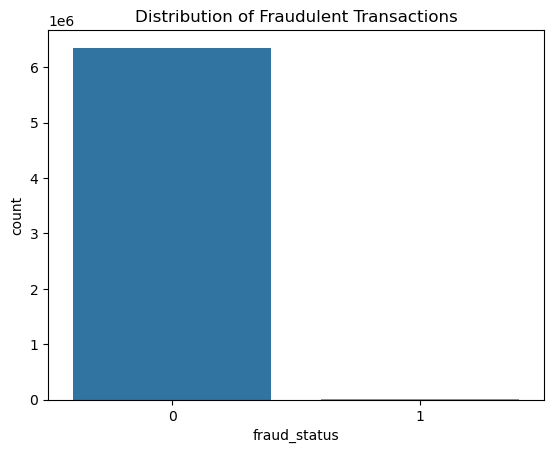

In [34]:
# Plot the distribution of fraud_status 
sns.countplot(data=df, x='fraud_status')
plt.title("Distribution of Fraudulent Transactions")
plt.show()
